In [1]:
import pandas as pd
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
# !pip install numpy==1.23.5
# !pip install --force-reinstall --no-cache-dir shap numba



In [3]:
import shap

In [4]:
X = pd.read_csv("data/processed_X.csv")
y = pd.read_csv("data/processed_y.csv").values.ravel()


In [5]:
#X = X.drop(columns=["TotalCharges"])

In [7]:
X.head(3)

gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0 -1.280248             0   
1       1              0        0           0  0.064303             1   
2       1              0        0           0 -1.239504             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  
0                 1              2       -1.161694     -0.994194  
1                 0              3       -0.260878     -0.173740  
2                 1              3       -0.363923     -0.959649

In [8]:
#pip install -U imbalanced-learn


In [9]:
y

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4922, 19)
X_test shape: (2110, 19)
y_train shape: (4922,)
y_test shape: (2110,)


In [11]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import time

def extended_grid_search(X_train, y_train, X_test, y_test):
    # models_params = {
    # 'LogisticRegression': {
    #     'model': Pipeline([
    #         ('scaler', StandardScaler()),
    #         ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
    #     ]),
    #     'params': {
    #         'clf__C': [0.01, 0.1, 1, 10]
    #     }
    # },
    # 'SVM': {
    #     'model': Pipeline([
    #         ('scaler', StandardScaler()),
    #         ('clf', SVC(class_weight='balanced',probability=True))
    #     ]),
    #     'params': {
    #         'clf__C': [0.1, 1, 10],
    #         'clf__kernel': ['linear', 'rbf'],
    #         'clf__gamma': ['scale', 'auto']
    #     }
    # },
    # 'NaiveBayes': {
    #     'model': ImbPipeline([
    #         ('smote', SMOTE()),
    #         ('clf', GaussianNB())
    #     ]),
    #     'params': {}
    # },
    # 'LDA': {
    #     'model': ImbPipeline([
    #         ('smote', SMOTE()),
    #         ('scaler', StandardScaler()),
    #         ('clf', LinearDiscriminantAnalysis())
    #     ]),
    #     'params': {}
    # },
    # 'QDA': {
    #     'model': ImbPipeline([
    #         ('smote', SMOTE()),
    #         ('scaler', StandardScaler()),
    #         ('clf', QuadraticDiscriminantAnalysis())
    #     ]),
    #     'params': {}
    # }
    # }

    models_params = {
          'LogisticRegression': {
              'model': Pipeline([
                  ('scaler', StandardScaler()),
                  ('clf', LogisticRegression(max_iter=1000))
              ]),
              'params': {'clf__C': [0.01, 0.1, 1, 10]
                        #'clf__solver': ['lbfgs', 'liblinear']
                        }
          },
          'SVM': {
              'model': Pipeline([
                  ('scaler', StandardScaler()),
                  ('clf', SVC())
              ]),
              'params': {'clf__C': [0.1, 1, 10],
                        'clf__kernel': ['linear', 'rbf'],
                        'clf__gamma': ['scale', 'auto']}
          },


          'NaiveBayes': {
              'model': GaussianNB(),
              'params': {}
          },
          'LDA': {
              'model': Pipeline([
                  ('scaler', StandardScaler()),
                  ('clf', LinearDiscriminantAnalysis())
              ]),
              'params': {}
          },
          'QDA': {
              'model': Pipeline([
                  ('scaler', StandardScaler()),
                  ('clf', QuadraticDiscriminantAnalysis())
              ]),
              'params': {}
          },

      }



    results = []
    best_models = {}
    total_models = len(models_params)

    for i, (name, mp) in enumerate(models_params.items(), 1):
        print(f"[{i}/{total_models}] Training {name}...")
        start = time.time()

        gs = GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        duration = time.time() - start

        print(f"[{i}/{total_models}] {name} finished in {duration:.2f}s — Accuracy: {acc:.4f}")

        results.append({
            'Model': name,
            'Accuracy': acc,
            'Best Params': gs.best_params_,
            'Train Time (s)': round(duration, 2)
        })

        best_models[name] = {
            'best_model': gs.best_estimator_,
            'test_accuracy': acc,
            'y_pred': y_pred
        }

        plot_decision_boundary(gs.best_estimator_, X_train, y_train,title=f"{name} (Train Set)", use_pca=True)
        plot_decision_boundary(gs.best_estimator_, X_test, y_test,
                       title=f"{name} (Test Set)", use_pca=True)




    results_df = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False).reset_index(drop=True)

    best_name = results_df.iloc[0]['Model']
    best_info = best_models[best_name]

    print(f"\nBest Model: {best_name}")
    print(f"Accuracy: {best_info['test_accuracy']:.4f}")
    print(f"Best Params: {results_df.iloc[0]['Best Params']}")

    return best_name, best_info['best_model'], best_info['test_accuracy'], best_info['y_pred'],results_df,best_models

In [12]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


def get_final_estimator(model):
    """Safely extracts the final classifier from a Pipeline object or returns the model itself."""
    # Check if the model is a Pipeline and the last step is a classifier
    if isinstance(model, Pipeline) and isinstance(model.steps[-1][1], (LogisticRegression, SVC, GaussianNB, LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis)):
        return model.steps[-1][1]
    return model

def plot_decision_boundary(model, X, y, title="Decision Boundary", use_pca=False):
    """
    Plots the decision boundary for a given model (optionally using PCA for reduction).

    The function clones and refits the model's final estimator (classifier)
    on 2-component PCA data for visualization, thus avoiding the ValueError
    from the original 19-feature StandardScaler/Pipeline.
    """
    X_plot = X.copy()
    y_plot = y.copy()

    # Determine the number of classes for plotting colors
    n_classes = len(np.unique(y_plot))
    cmap_light = ListedColormap(sns.color_palette("pastel", n_classes))
    cmap_bold = ListedColormap(sns.color_palette("dark", n_classes))

    # Handle PCA for high-dimensional data visualization
    if X_plot.shape[1] > 2 and use_pca:
        print("Data reduced to 2D using PCA for visualization.")

        # 1. Fit PCA on the full high-dimensional data
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_plot)

        # 2. Extract the base classifier
        base_classifier = get_final_estimator(model)

        # 3. Clone and Refit the 2D classifier on the PCA-transformed data
        # This new 2D model is only for plotting.
        model_2d = clone(base_classifier)
        try:
            model_2d.fit(X_2d, y_plot)
        except Exception as e:
            print(f"Could not refit 2D classifier for plotting ({model_2d.__class__.__name__}): {e}")
            return # Skip plotting for this model

        X_plot = X_2d

    # If not using PCA, or if data is already 2D
    elif X_plot.shape[1] == 2:
        model_2d = get_final_estimator(model)
    else:
        print(f"Cannot plot decision boundary: Data has {X_plot.shape[1]} features (must be 2 after PCA).")
        return

    # Create the Mesh Grid
    x_min, x_max = X_plot[:, 0].min() - 0.1, X_plot[:, 0].max() + 0.1
    y_min, y_max = X_plot[:, 1].min() - 0.1, X_plot[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))

    # Predict on the grid using the 2D-fitted model
    try:
        Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
    except Exception as e:
        print(f"Prediction on mesh grid failed for {title}: {e}")
        return

    Z = Z.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.7)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, cmap=cmap_bold, edgecolor='k', s=40)

    # Final Plot Labels
    clf_name = model_2d.__class__.__name__
    if use_pca and X.shape[1] > 2:
        plt.title(f"{clf_name} Decision Boundary with PCA - {title}")
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
    else:
        plt.title(title)

    plt.show()

[1/5] Training LogisticRegression...
[1/5] LogisticRegression finished in 12.94s — Accuracy: 0.8076
Data reduced to 2D using PCA for visualization.


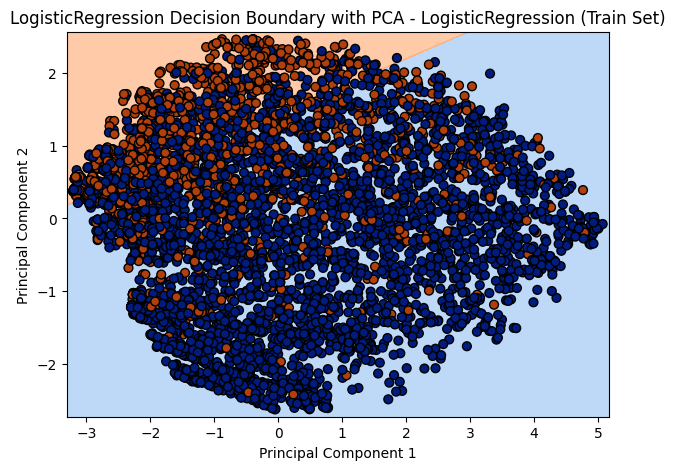

Data reduced to 2D using PCA for visualization.


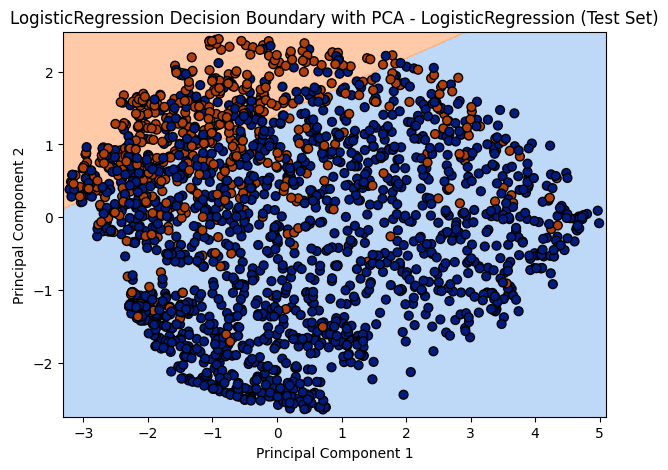

[2/5] Training SVM...
[2/5] SVM finished in 38.81s — Accuracy: 0.7991
Data reduced to 2D using PCA for visualization.


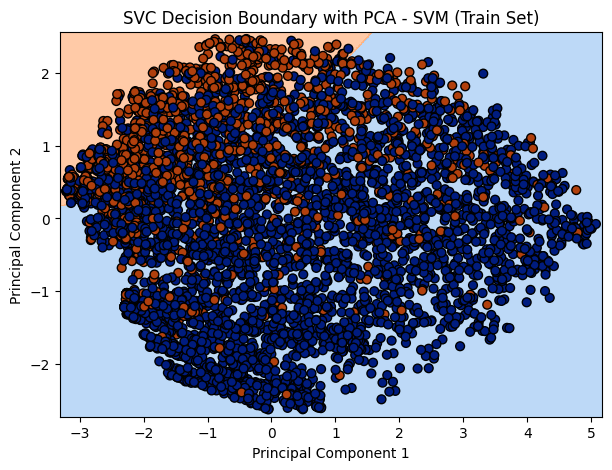

Data reduced to 2D using PCA for visualization.


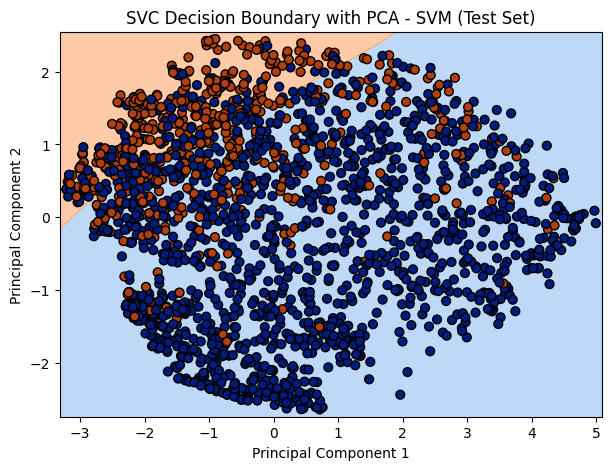

[3/5] Training NaiveBayes...
[3/5] NaiveBayes finished in 0.14s — Accuracy: 0.7640
Data reduced to 2D using PCA for visualization.


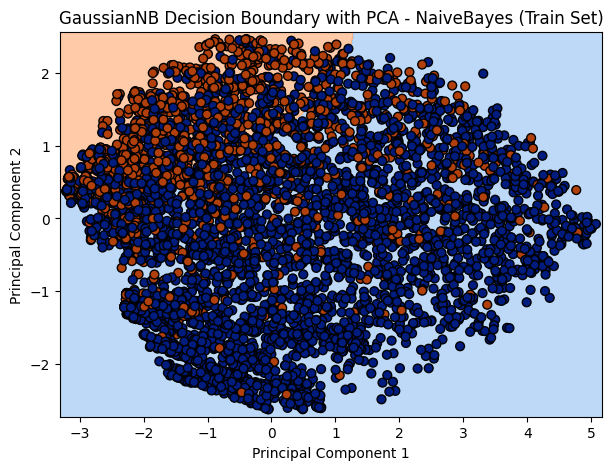

Data reduced to 2D using PCA for visualization.


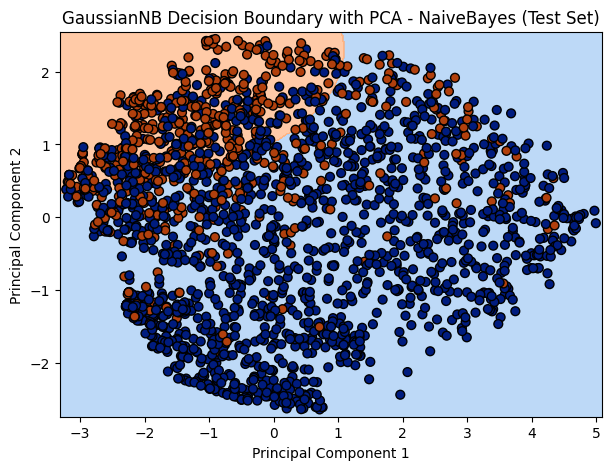

[4/5] Training LDA...
[4/5] LDA finished in 0.28s — Accuracy: 0.8005
Data reduced to 2D using PCA for visualization.


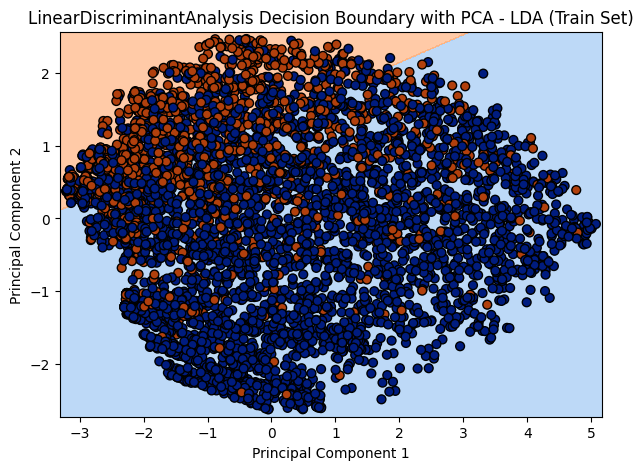

Data reduced to 2D using PCA for visualization.


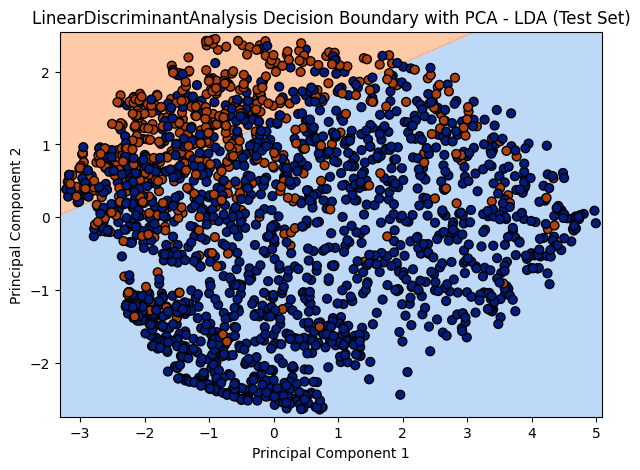

[5/5] Training QDA...
[5/5] QDA finished in 0.22s — Accuracy: 0.7621
Data reduced to 2D using PCA for visualization.


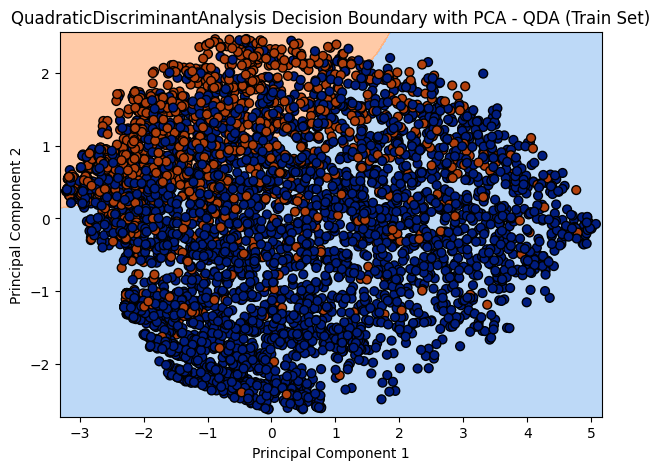

Data reduced to 2D using PCA for visualization.


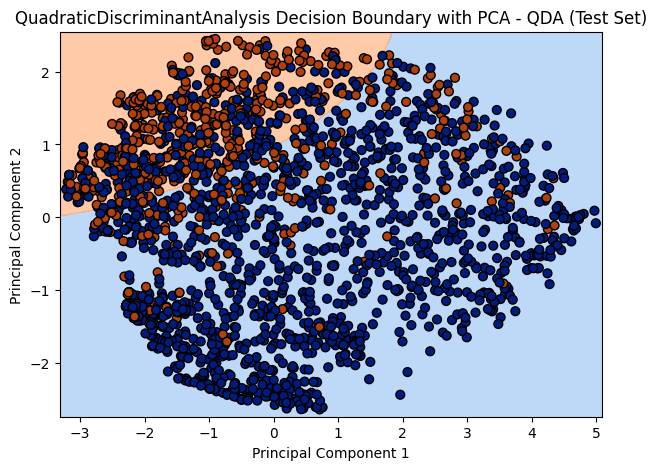


Best Model: LogisticRegression
Accuracy: 0.8076
Best Params: {'clf__C': 0.1}
Best Model: LogisticRegression
Accuracy: 0.8076


In [13]:
best_name, best_model, best_acc ,best_y_pred,results_df,best_models= extended_grid_search(X_train, y_train, X_test, y_test)

print(f"Best Model: {best_name}")
print(f"Accuracy: {best_acc:.4f}")

F1 Score for LogisticRegression: 0.6119

Confusion Matrix:
[[1384  165]
 [ 241  320]]


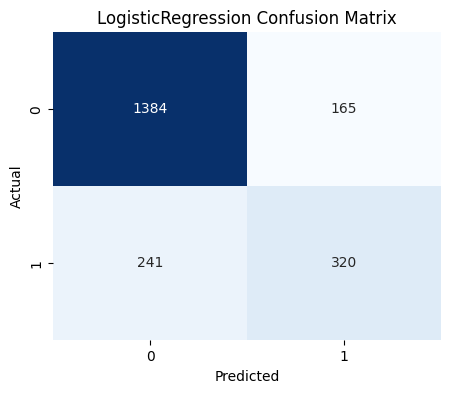


Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.66      0.57      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



In [14]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

f1 = f1_score(y_test, best_y_pred)
print(f"F1 Score for {best_name}: {f1:.4f}\n")


cm = confusion_matrix(y_test, best_y_pred)
print("Confusion Matrix:")
print(cm)

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"{best_name} Confusion Matrix")
plt.show()


print("\nClassification Report:\n")
print(classification_report(y_test, best_y_pred))

In [15]:
best_acc

0.8075829383886256

In [16]:
results_df

Model  Accuracy  \
0  LogisticRegression  0.807583   
1                 LDA  0.800474   
2                 SVM  0.799052   
3          NaiveBayes  0.763981   
4                 QDA  0.762085   

                                         Best Params  Train Time (s)  
0                                    {'clf__C': 0.1}           12.94  
1                                                 {}            0.28  
2  {'clf__C': 1, 'clf__gamma': 'scale', 'clf__ker...           38.81  
3                                                 {}            0.14  
4                                                 {}            0.22

In [17]:
models = {name: info["best_model"] for name, info in best_models.items()}



===================== LogisticRegression =====================

Confusion Matrix:
[[1384  165]
 [ 241  320]]


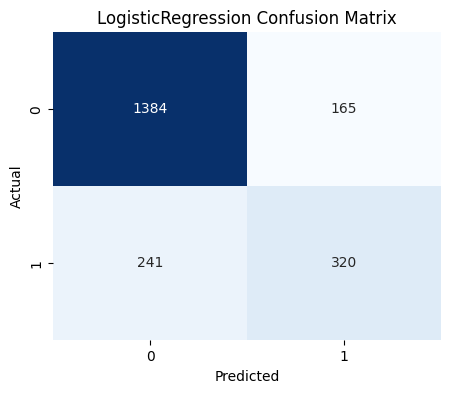

Precision: 0.8007
Recall:    0.8076
F1 Score:  0.8029

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.66      0.57      0.61       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110


===================== SVM =====================

Confusion Matrix:
[[1404  145]
 [ 279  282]]


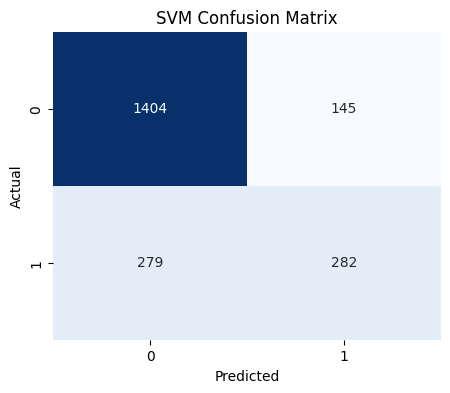

Precision: 0.7880
Recall:    0.7991
F1 Score:  0.7896

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1549
           1       0.66      0.50      0.57       561

    accuracy                           0.80      2110
   macro avg       0.75      0.70      0.72      2110
weighted avg       0.79      0.80      0.79      2110


===================== NaiveBayes =====================

Confusion Matrix:
[[1181  368]
 [ 130  431]]


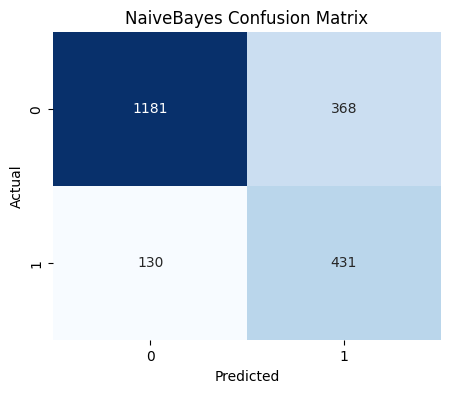

Precision: 0.8047
Recall:    0.7640
F1 Score:  0.7748

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      1549
           1       0.54      0.77      0.63       561

    accuracy                           0.76      2110
   macro avg       0.72      0.77      0.73      2110
weighted avg       0.80      0.76      0.77      2110


===================== LDA =====================

Confusion Matrix:
[[1375  174]
 [ 247  314]]


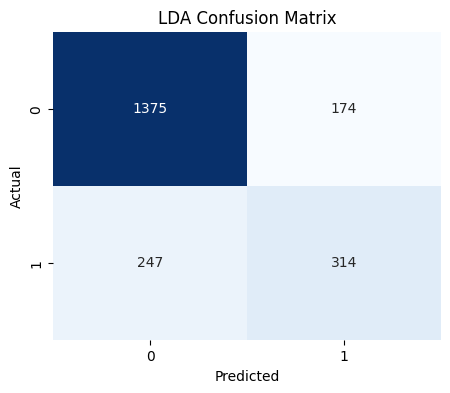

Precision: 0.7934
Recall:    0.8005
F1 Score:  0.7958

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1549
           1       0.64      0.56      0.60       561

    accuracy                           0.80      2110
   macro avg       0.75      0.72      0.73      2110
weighted avg       0.79      0.80      0.80      2110


===================== QDA =====================

Confusion Matrix:
[[1178  371]
 [ 131  430]]


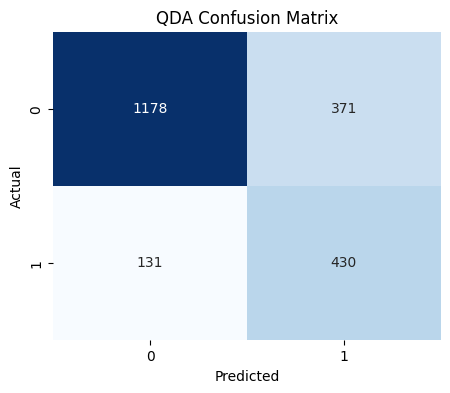

Precision: 0.8034
Recall:    0.7621
F1 Score:  0.7731

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      1549
           1       0.54      0.77      0.63       561

    accuracy                           0.76      2110
   macro avg       0.72      0.76      0.73      2110
weighted avg       0.80      0.76      0.77      2110



In [18]:
from sklearn.metrics import (
    confusion_matrix, classification_report,
    accuracy_score, precision_score, recall_score, f1_score
)
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, model in models.items():

    print(f"\n===================== {model_name} =====================\n")

    y_pred = model.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{model_name} Confusion Matrix")
    plt.show()

    # Precision, Recall, F1
    precision = precision_score(y_test, y_pred, average='weighted')
    recall    = recall_score(y_test, y_pred, average='weighted')
    f1        = f1_score(y_test, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}\n")

    # Full Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


In [19]:
# # Extract the logistic regression model from pipeline
# logreg = best_model.named_steps['clf']

# # Get absolute coefficients as feature importance
# feature_importance = np.abs(logreg.coef_[0])

# # Assuming X_train is a DataFrame for feature names
# feature_names = X_train.columns

# # Create a DataFrame for feature importance
# df_importance = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
# df_importance = df_importance.sort_values(by='Importance', ascending=False)
# print(df_importance)


NB:

In [20]:



# 2. Calculate the Correlation Matrix (R)
R = X.corr()



Correlation_Heatmap.png saved successfully. Examine it to validate the NB failure.


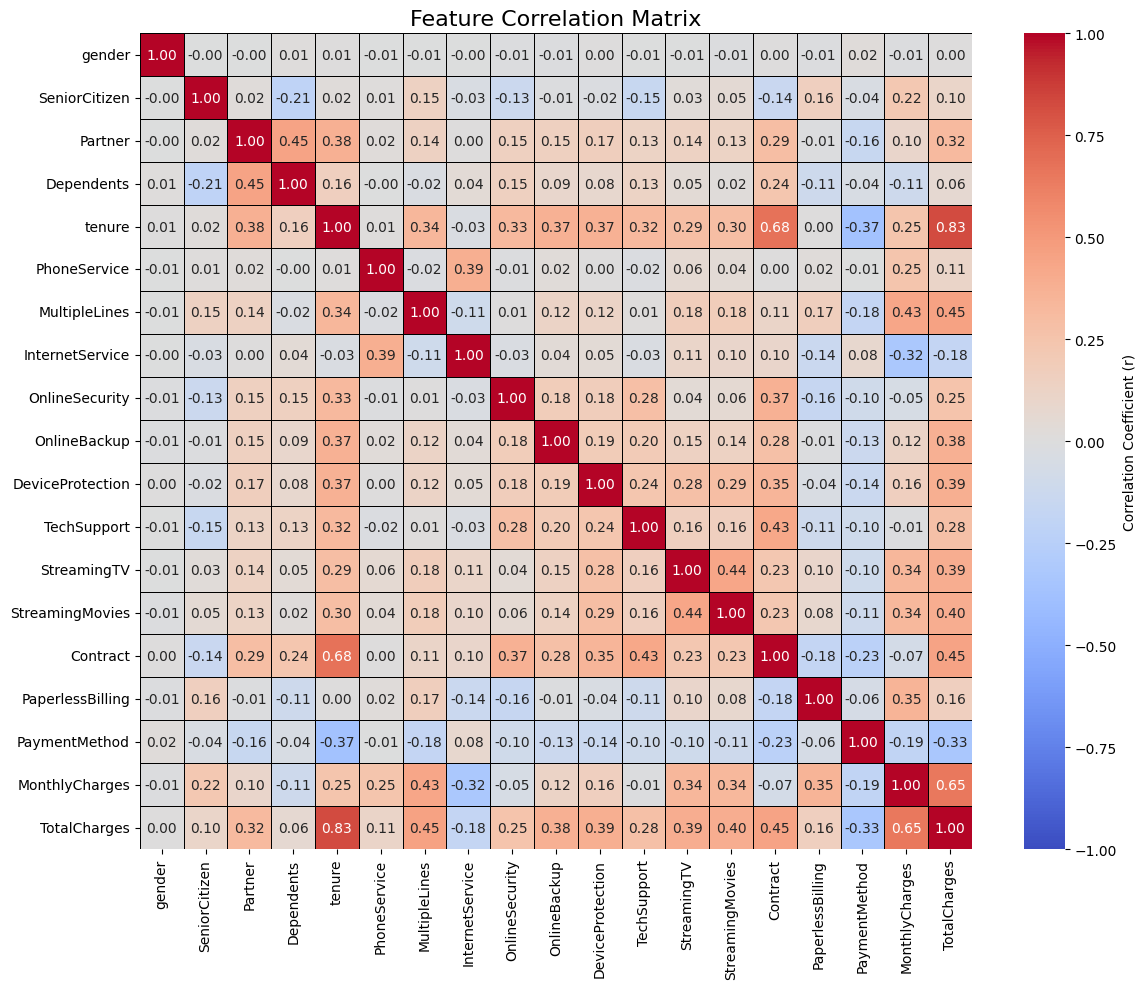

In [21]:
# 3. Visualize the Correlation Matrix as a Heatmap
plt.figure(figsize=(12, 10))

# Using 'annot=False' for cleaner visualization of 19 features,
# but 'annot=True' can be used if you prefer to see the values.
sns.heatmap(R, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, linecolor='black',
            vmax=1.0, vmin=-1.0, cbar_kws={'label': 'Correlation Coefficient (r)'})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.tight_layout()

# Save the plot
plt.savefig('Correlation_Heatmap.png')
print("Correlation_Heatmap.png saved successfully. Examine it to validate the NB failure.")

In [22]:


# 1. Assume R (the correlation matrix) is loaded from X.corr()
# If you need to re-load R, use: R = X.corr()
# For demonstration, we'll assume R is the last calculated correlation matrix.

# Assuming your features DataFrame X has 19 columns:
num_features = 19

# Convert the correlation matrix to a NumPy array for easier manipulation
R_values = R.values

# 2. Create a mask to exclude the diagonal (where r = 1.0)
# The diagonal represents the correlation of a feature with itself.
np.fill_diagonal(R_values, np.nan)

# 3. Apply the absolute threshold and count the occurrences
threshold = 0.3
# Count how many values are above the threshold
high_corr_count = np.sum(np.abs(R_values) > threshold)

# The matrix R is symmetric (r_ij = r_ji), so we divide by 2 to count unique pairs.
unique_high_corr_pairs = int(high_corr_count / 2)

print(f"Total number of unique feature pairs with |r| > {threshold}: {unique_high_corr_pairs}")

Total number of unique feature pairs with |r| > 0.3: 29


QDA

In [23]:
# Assuming D is the number of features based on your data (D=19)
D = 19

# Calculate parameters for LDA
lda_mean_params = 2 * D
lda_cov_params = D * (D + 1) // 2 # Only one shared covariance matrix
lda_total_params = lda_mean_params + lda_cov_params

# Calculate parameters for QDA
qda_mean_params = 2 * D
qda_cov_params = 2 * (D * (D + 1) // 2) # Two separate covariance matrices
qda_total_params = qda_mean_params + qda_cov_params

print(f"--- Model Complexity (D={D}) ---")
print(f"LDA (Linear): Total Parameters = {lda_total_params}")
print(f"QDA (Quadratic): Total Parameters = {qda_total_params}")
print(f"QDA is {qda_total_params / lda_total_params:.2f} times more complex than LDA.")

--- Model Complexity (D=19) ---
LDA (Linear): Total Parameters = 228
QDA (Quadratic): Total Parameters = 418
QDA is 1.83 times more complex than LDA.


In [24]:
import pandas as pd
import numpy as np
from numpy.linalg import det, norm

# NOTE: Ensure these files paths are correct in your environment
try:
    X = pd.read_csv("data/processed_X.csv")
    y = pd.read_csv("data/processed_y.csv").values.ravel()
except FileNotFoundError:
    print("Error: Files not found. Please run this code where 'data/processed_X.csv' and 'data/processed_y.csv' are accessible.")
    # Exit if data is not loaded

# 1. Split data by class
X_class_0 = X[y == 0]
X_class_1 = X[y == 1]

# 2. Calculate the covariance matrix for each class
# rowvar=False ensures features are columns
Sigma_0 = np.cov(X_class_0, rowvar=False)
Sigma_1 = np.cov(X_class_1, rowvar=False)


# 3. Calculate key properties
det_0 = det(Sigma_0)
det_1 = det(Sigma_1)

trace_0 = np.trace(Sigma_0)
trace_1 = np.trace(Sigma_1)

# 4. Calculate the Frobenius norm (matrix distance) - an advanced metric
# Measures the 'size' of the difference between the two matrices
frobenius_norm_diff = norm(Sigma_0 - Sigma_1, 'fro')

# 5. Output Results
print("=" * 50)
print("     LDA vs. QDA: Covariance Matrix Proof (D=19)")
print("=" * 50)
print(f"Sample Sizes (N0/N1): {len(X_class_0)} / {len(X_class_1)}")
print("-" * 50)
print("A. Volume of Data Spread (Determinant)")
print(f"  Determinant(Σ0) [Class 0]: {det_0:.4e}")
print(f"  Determinant(Σ1) [Class 1]: {det_1:.4e}")
print(f"  Ratio (Max/Min): {max(det_0, det_1) / min(det_0, det_1):.2f}x")
print("\nB. Total Feature Variance (Trace)")
print(f"  Trace(Σ0) [Class 0]: {trace_0:.4f}")
print(f"  Trace(Σ1) [Class 1]: {trace_1:.4f}")
print(f"  Ratio (Max/Min): {max(trace_0, trace_1) / min(trace_0, trace_1):.2f}x")
print("\nC. Matrix Distance (Frobenius Norm)")
print(f"  ||Σ0 - Σ1||_F: {frobenius_norm_diff:.4f} (Measure of Difference)")

     LDA vs. QDA: Covariance Matrix Proof (D=19)
Sample Sizes (N0/N1): 5163 / 1869
--------------------------------------------------
A. Volume of Data Spread (Determinant)
  Determinant(Σ0) [Class 0]: 5.3033e-09
  Determinant(Σ1) [Class 1]: 7.2605e-11
  Ratio (Max/Min): 73.04x

B. Total Feature Variance (Trace)
  Trace(Σ0) [Class 0]: 12.1395
  Trace(Σ1) [Class 1]: 9.8268
  Ratio (Max/Min): 1.24x

C. Matrix Distance (Frobenius Norm)
  ||Σ0 - Σ1||_F: 1.8523 (Measure of Difference)


In [25]:
Sigma_0.shape


(19, 19)

In [26]:
Sigma_1.shape

(19, 19)

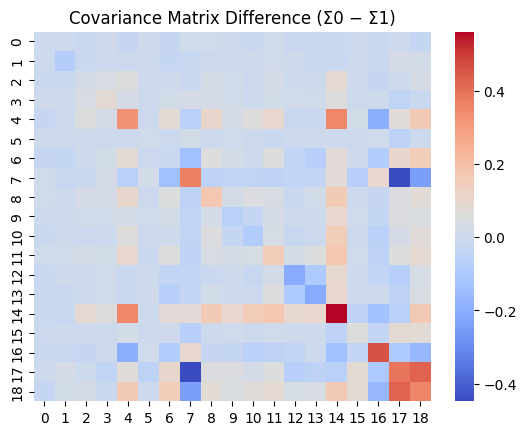

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(Sigma_0 - Sigma_1, annot=False, cmap="coolwarm")
plt.title("Covariance Matrix Difference (Σ0 − Σ1)")
plt.show()


In [28]:
import numpy as np

diff = np.linalg.norm(Sigma_0 - Sigma_1, ord='fro')
print("Matrix Difference:", diff)


Matrix Difference: 1.852300321375253


In [29]:
import shap
shap.initjs()

# Your trained logistic regression model
model_lr = best_models["LogisticRegression"]["best_model"]

# If model uses a Pipeline, extract components
clf_lr = model_lr.named_steps["clf"]
scaler = model_lr.named_steps["scaler"]

# Transform X for SHAP
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SHAP Explainer
explainer_lr = shap.LinearExplainer(clf_lr, X_train_scaled)

# SHAP values
shap_values_lr = explainer_lr.shap_values(X_test_scaled)


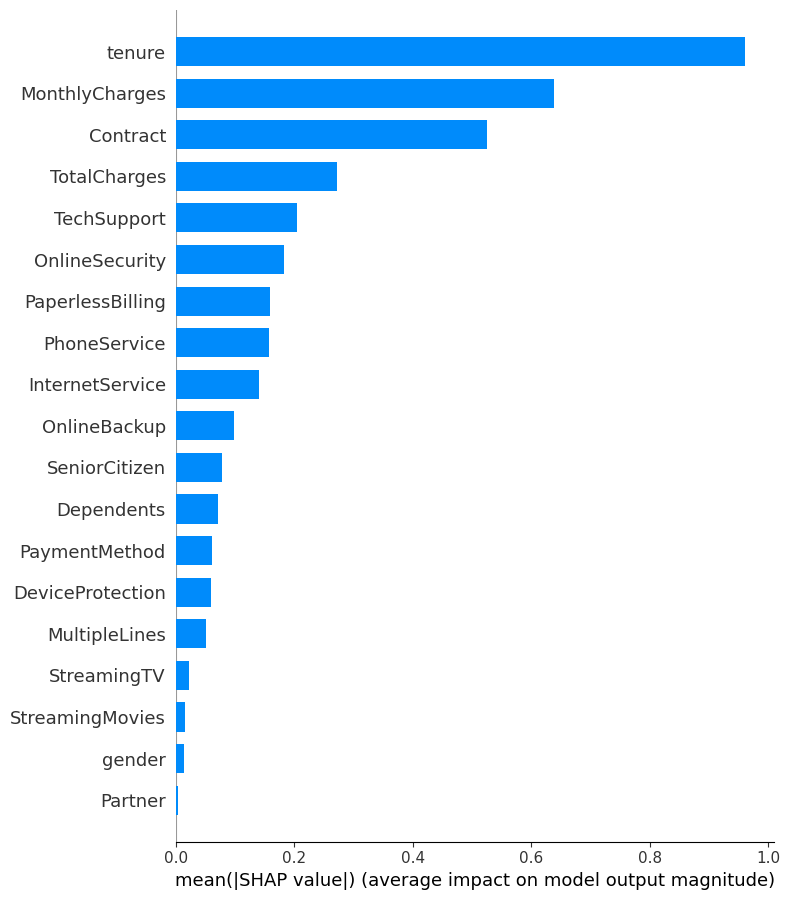

In [30]:
# Bar chart for feature importance
shap.summary_plot(
    shap_values_lr,
    X_test,
    plot_type="bar",
    feature_names=X_train.columns
)


In [31]:
# import shap
# import numpy as np

# shap.initjs()

# # Your trained SVM model from pipeline
# model_svm = best_models["SVM"]["best_model"]

# clf_svm = model_svm.named_steps["clf"]
# scaler_svm = model_svm.named_steps["scaler"]

# # Scale data
# X_train_scaled = scaler_svm.transform(X_train)
# X_test_scaled = scaler_svm.transform(X_test)

# # Kernel SHAP works with predict_proba
# # If SVM has no probability=True, SHAP will not work
# def f(X):
#     return clf_svm.predict_proba(X)

# # Use small background set (Kernel SHAP is slow!)
# background = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 50, replace=False)]

# explainer_svm = shap.KernelExplainer(f, background)

# # Compute SHAP values (slow → use 100 samples or fewer)
# shap_values_svm = explainer_svm.shap_values(X_test_scaled[:100])

# # Summary plot
# shap.summary_plot(shap_values_svm, X_test_scaled[:100], feature_names=X_train.columns)


In [32]:
# Assuming X_test is your pandas DataFrame containing the original feature names
# and that explainer_lr.expected_value is a single scalar.

shap.plots.force(
    # Use the expected value without an index, as it is a scalar
    base_value=explainer_lr.expected_value, 
    
    # Use the SHAP values for the 7th sample (index 6) without a class index
    shap_values=shap_values_lr[6],
    
    # Pass the feature names from your original data
    features=X_test.iloc[6], # Optional, but recommended to show feature values
    feature_names=X_test.columns.tolist() 
)

In [33]:
import pickle
# Assume `best_log_reg_model` is your final trained Logistic Regression model
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)